# Importing Libraries

Install neccessary libraries

In [ ]:
#!pip install --upgrade tensorflow
#!pip install matplotlib
#!pip install pandas
#!pip install seaborn
#!pip install scipy


Upload and Unpack Dataset Zip Files in Google Colab

Dataset Sources:

    [UTKFace Dataset](https://www.kaggle.com/datasets/jangedoo/utkface-new)
    [Face Expression Recognition Dataset](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset)

Note: I repeated the code for uploading each file individually to ensure that each dataset is properly uploaded. This approach was taken because uploading multiple files simultaneously seemed to be significantly slower.

In [78]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [98]:
import zipfile
import os

zip_ref = zipfile.ZipFile("/content/archive.zip")
zip_ref.extractall("/content/age_gender_destination_folder")
zip_ref.close()

In [77]:
from google.colab import files
uploaded = files.upload()


In [3]:
import zipfile
import os

zip_ref = zipfile.ZipFile("/content/images.zip")
zip_ref.extractall("/content/destination_folder")
zip_ref.close()


Importing neccessary libraries

In [85]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import tensorflow as tf
# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras import layers as L

# Mixed Precision Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



#Displaying Emotion Images

In [86]:
picture_size = 48
folder_path = '/content/destination_folder/images/'


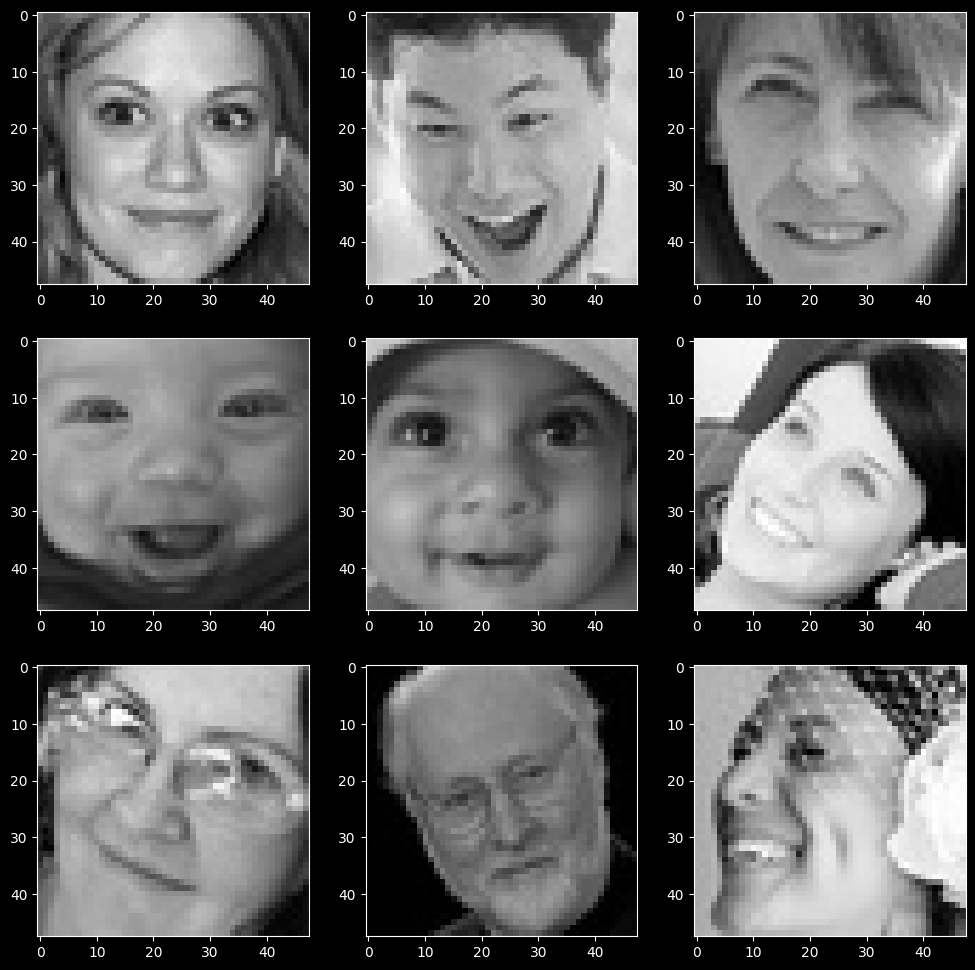

In [87]:
# Sets the expression category to 'happy'
expression = 'happy'

# Creates a 12x12 inch size figure for plotting
plt.figure(figsize= (12,12))

# Loops through the first 9 images in the folder and creates a subplott ina 3x3 grid
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
# Displays all the subplots together
plt.show()

# Making Training and Validation Data for Emotion Dataset

In [88]:
# Set the batch size for training and validation
batch_size = 128

# Initialize an ImageDataGenerator for the training set with data augmentation
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,# Randomly flip images horizontally
    #brightness_range=[0.2, 1.0],  # Adding brightness variation
    brightness_range=[0.1, 1.0],  # Lowering brightness to simulate low-light
    fill_mode='nearest'
)

# Initialize an ImageDataGenerator for the validation set without augmentation
datagen_val = ImageDataGenerator(rescale=1./255)

# Load the training data from the specified directory using the training ImageDataGenerator
train_set = datagen_train.flow_from_directory(
    folder_path + "train",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical', # Use categorical labels (one-hot encoded)
    shuffle=True
)

# Convert the training set to a TensorFlow Dataset object for better performance and pipeline control
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_set,
    output_signature=(
        tf.TensorSpec(shape=(None, picture_size, picture_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 7), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE) # Prefetch batches for efficient processing

# Load the validation data from the specified directory using the validation ImageDataGenerator
test_set = datagen_val.flow_from_directory(
    folder_path + "validation",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Do not shuffle the validation data
)

# Convert the validation set to a TensorFlow Dataset object for better performance and pipeline control
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_set,
    output_signature=(
        tf.TensorSpec(shape=(None, picture_size, picture_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 7), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE) # Prefetch batches for efficient processing




Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model Building

In [89]:
no_of_classes = 7

# Initialize a Sequential model
model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))


# Setting learning rate
opt = Adam(learning_rate = 0.0001)

# Compile the model
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_54 (Activation)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_55 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_56 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_57 (Activation)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Fitting the Model with Training and Validation Data

In [90]:
# Define a checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("./model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

# Define a learning rate reduction callback to adjust the learning rate if training plateaus
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

# Combine all the callbacks into a list
callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

# Number of epochs for training
epochs = 48

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [91]:
# Train the model using the training dataset and validate it using the validation dataset
history = model.fit(
    train_dataset,
    steps_per_epoch=train_set.n // batch_size,
    epochs=epochs,
    validation_data=test_dataset,
    validation_steps=test_set.n // batch_size,
    callbacks=callbacks_list
)


Epoch 1/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.1918 - loss: 2.1286
Epoch 1: val_accuracy improved from -inf to 0.25923, saving model to ./model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accuracy: 0.1919 - loss: 2.1281 - val_accuracy: 0.2592 - val_loss: 1.8283 - learning_rate: 1.0000e-04
Epoch 2/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2136 - loss: 1.9658
Epoch 2: val_accuracy improved from 0.25923 to 0.26362, saving model to ./model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.2136 - loss: 1.9657 - val_accuracy: 0.2636 - val_loss: 1.8279 - learning_rate: 1.0000e-04
Epoch 3/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2304 - loss: 1.9048
Epoch 3: val_accuracy improved from 0.26362 to 0.29922, saving model to ./model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.2304 - loss: 1.9047 - val_accuracy: 0.2992 - val_loss: 1.7398 - learning_rate: 1.0000e-04
Epoch 4/48
225/225 ━━━━━━━━━━━━━━━━━━

# Plotting Accuracy & Loss


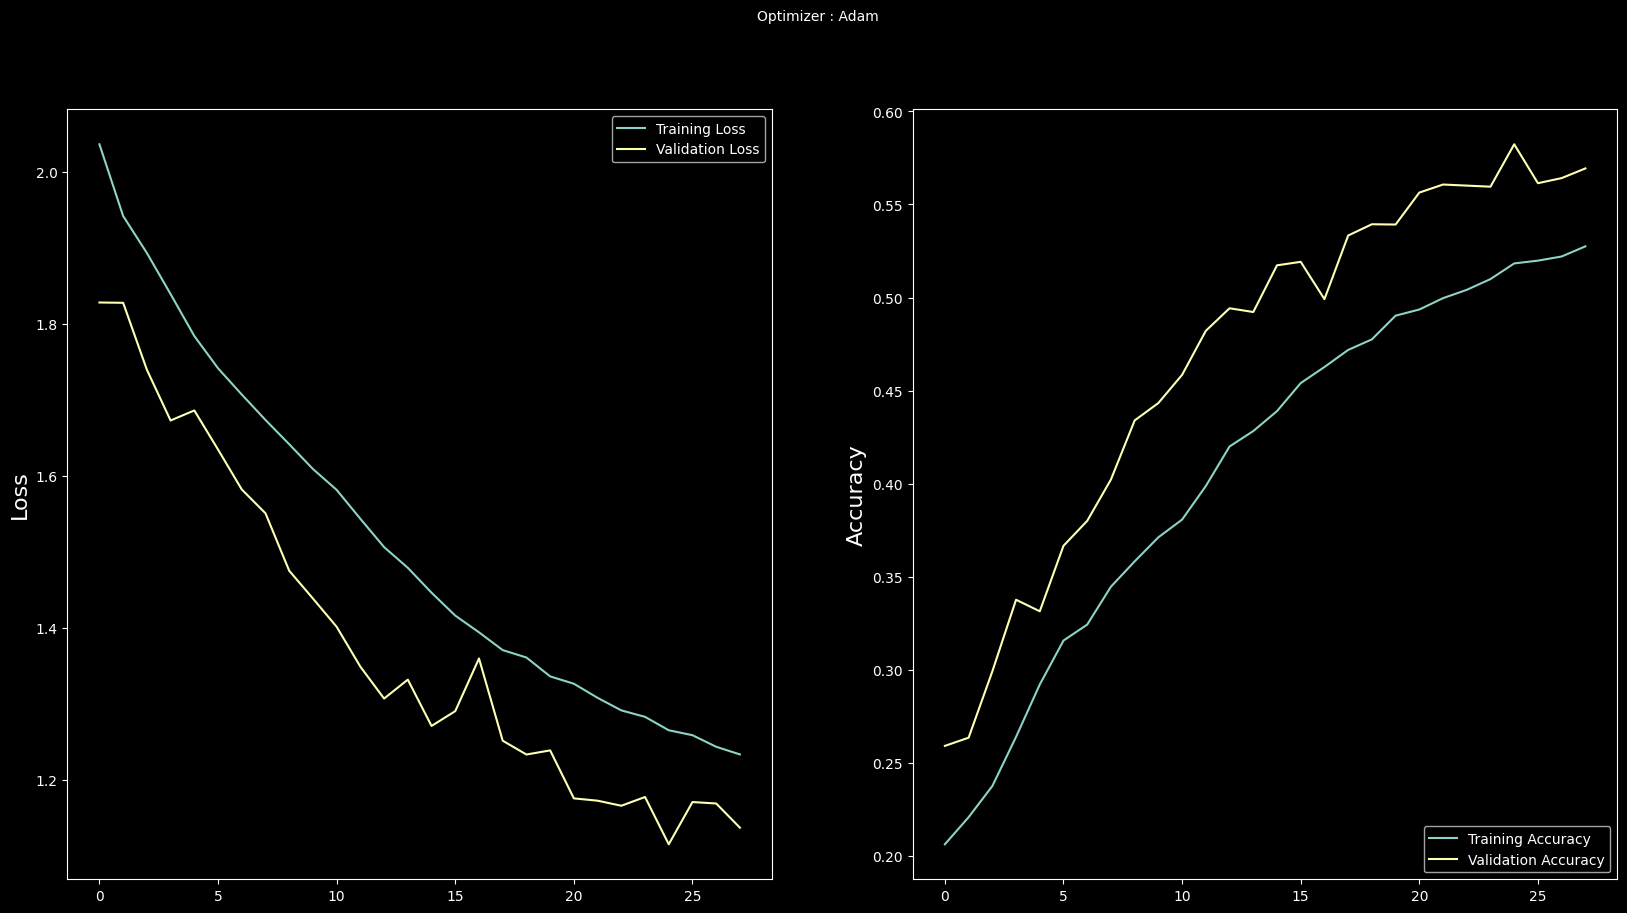

In [92]:
# Set the plot style to use a dark background
plt.style.use('dark_background')

plt.figure(figsize=(20,10))

# Create the first subplot for Loss
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# Create the second subplot for Accuracy
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

# Display the plots
plt.show()

In [93]:
model.save('model.h5')

In [94]:
model.save('model.keras')

# Displaying Age and Gender Images/EDA

In [116]:
# Initialize lists to store images, ages, and genders
images = []
ages = []
genders = []

# Directory where the dataset is stored
dataset_dir = '/content/age_gender_destination_folder/UTKFace/'

# Loop through each image file in the directory
for i in os.listdir(dataset_dir):
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(os.path.join(dataset_dir, i))

# Convert the lists to pandas Series
images = pd.Series(images, name='Name')
ages = pd.Series(ages, name='Age')
genders = pd.Series(genders, name='Gender')

# Concatenate into a DataFrame
df = pd.concat([images, ages, genders], axis=1)

# Display the first few rows of the DataFrame
df.head()

,Name,Age,Gender
0,/content/age_gender_destination_folder/UTKFace...,9,0
1,/content/age_gender_destination_folder/UTKFace...,51,0
2,/content/age_gender_destination_folder/UTKFace...,31,0
3,/content/age_gender_destination_folder/UTKFace...,60,1
4,/content/age_gender_destination_folder/UTKFace...,48,0


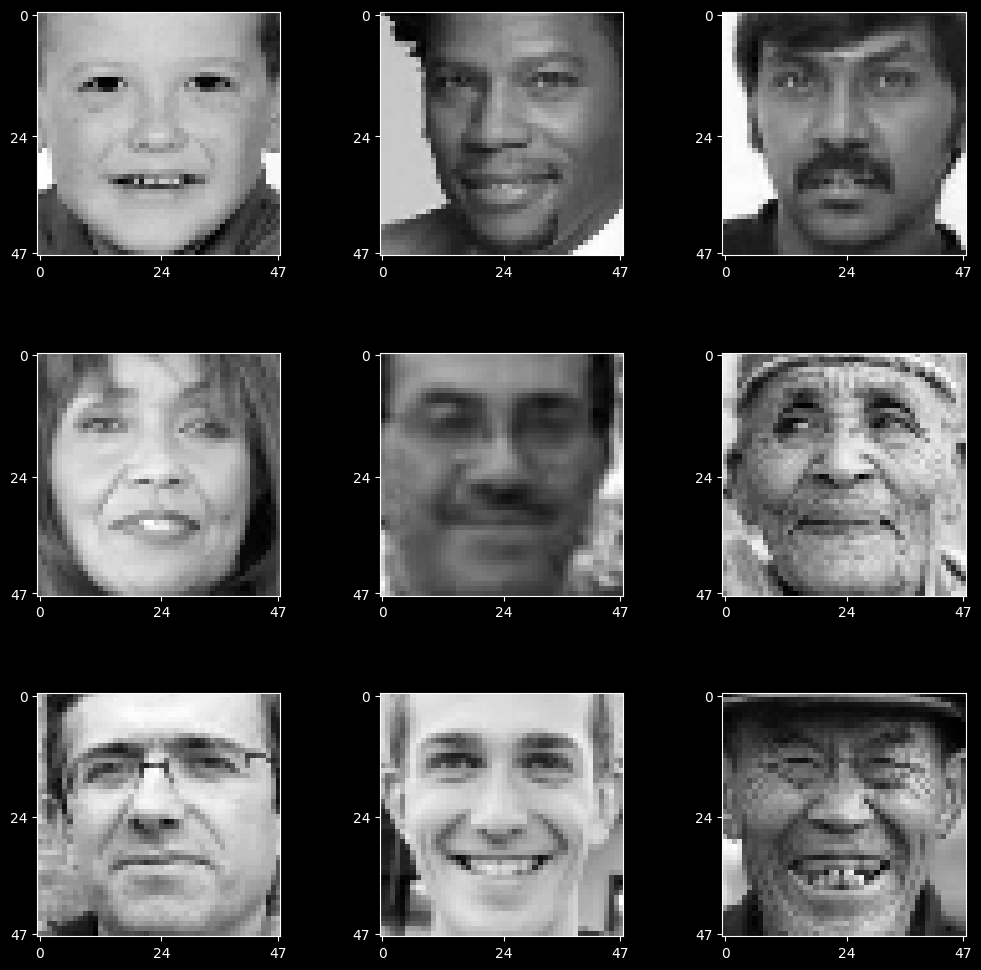

In [117]:
# Display images in a 3x3 grid in grayscale with scales visible, resized to 48x48
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = cv2.imread(df.iloc[i-1]['Name'], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))  # Resize the image to 48x48 pixels
    plt.imshow(img, cmap='gray')
    plt.gca().set_xticks([0, 24, 47])  # Set x-axis ticks for resized image
    plt.gca().set_yticks([0, 24, 47])  # Set y-axis ticks for resized image
    plt.gca().set_xticklabels([0, 24, 47])
    plt.gca().set_yticklabels([0, 24, 47])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust space between plots

plt.show()

,Name,Age,Gender
0,/content/age_gender_destination_folder/UTKFace...,9,0
1,/content/age_gender_destination_folder/UTKFace...,51,0
2,/content/age_gender_destination_folder/UTKFace...,31,0
3,/content/age_gender_destination_folder/UTKFace...,60,1
4,/content/age_gender_destination_folder/UTKFace...,48,0


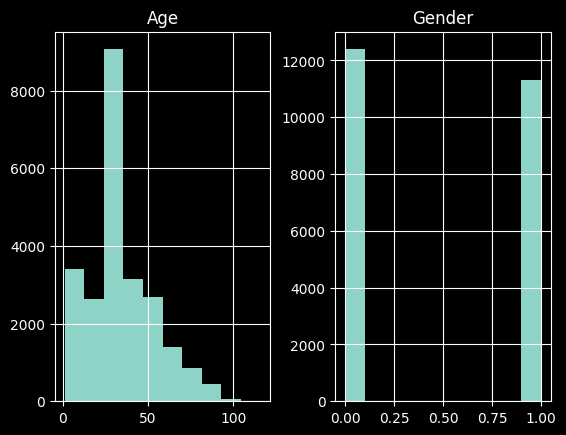

In [118]:
df.hist() # Generates histograms for each column in the DataFrame, showing the distribution of ages and genders.
df = df[(df['Age'] <= 90) & (df['Age'] >= 0)]
df = df.reset_index(drop=True)
df.head() # Displays the first few rows of the updated DataFrame.

# Splitting Data for Age and Gender Prediction

In [119]:
from sklearn.model_selection import train_test_split

x=df['Name']
y_age=df['Age']
y_gender=df['Gender']

# Splits the data into training and validation sets for age prediction, with 10% of the data used for validation.
x_train_age,x_val_age, y_train_age, y_val_age=train_test_split(x,y_age,test_size=0.1)

#Splits the data into training and validation sets for gender prediction, ensuring that the distribution of genders is maintained (stratified sampling).
x_train_gender,x_val_gender,y_train_gender,y_val_gender=train_test_split(x,y_gender,test_size=0.1, stratify=y_gender)


# Creating DataFrames for Training and Validation

In [120]:
# Creates a dictionary with the training image paths and ages.
d={'Name':x_train_age,'Age':y_train_age}
df_train_age=pd.concat(d,axis=1)
df_train_age.head()


,Name,Age
19198,/content/age_gender_destination_folder/UTKFace...,5
13712,/content/age_gender_destination_folder/UTKFace...,1
17654,/content/age_gender_destination_folder/UTKFace...,27
13450,/content/age_gender_destination_folder/UTKFace...,25
8744,/content/age_gender_destination_folder/UTKFace...,10


In [121]:
# Creates a dictionary with the training image paths and genders.
d={'Name':x_train_gender,'Gender':y_train_gender}
df_train_gender=pd.concat(d,axis=1)
df_train_gender.head()


,Name,Gender
21545,/content/age_gender_destination_folder/UTKFace...,0
23138,/content/age_gender_destination_folder/UTKFace...,1
9866,/content/age_gender_destination_folder/UTKFace...,0
17861,/content/age_gender_destination_folder/UTKFace...,0
23243,/content/age_gender_destination_folder/UTKFace...,0


In [122]:
# Creates a dictionary with the validation image paths and genders.
d={'Name':x_val_gender,'Gender':y_val_gender}
df_val_gender=pd.concat(d,axis=1)
df_val_gender.head()

,Name,Gender
10764,/content/age_gender_destination_folder/UTKFace...,0
1947,/content/age_gender_destination_folder/UTKFace...,1
21025,/content/age_gender_destination_folder/UTKFace...,1
19736,/content/age_gender_destination_folder/UTKFace...,1
23557,/content/age_gender_destination_folder/UTKFace...,0


In [123]:
# Creates a dictionary with the validation image paths and ages.
d={'Name':x_val_age,'Age':y_val_age}
df_val_age=pd.concat(d,axis=1)
df_val_age.head()

,Name,Age
6610,/content/age_gender_destination_folder/UTKFace...,63
10598,/content/age_gender_destination_folder/UTKFace...,26
6369,/content/age_gender_destination_folder/UTKFace...,35
12913,/content/age_gender_destination_folder/UTKFace...,1
362,/content/age_gender_destination_folder/UTKFace...,31


# Data Augmentation and Generation for Age Prediction

In [124]:
df_train_age['Age']=df_train_age['Age'].astype('str')
batch=512
train_gen_age=ImageDataGenerator(rescale=1./255)
train_data_age=train_gen_age.flow_from_dataframe(dataframe=df_train_age,
                                            x_col='Name',
                                            y_col='Age',
                                            seed=42,
                                            batch_size=batch,
                                            shuffle=True,
                                            class_mode='sparse',
                                            target_size=(224,224))


Found 21258 validated image filenames belonging to 90 classes.


# Data Augmentation and Generation for Gender Prediction

In [125]:
df_train_gender['Gender']=df_train_gender['Gender'].astype('str')
train_gen_gender=ImageDataGenerator(rescale=1./255)
train_data_gender=train_gen_gender.flow_from_dataframe(dataframe=df_train_gender,
                                            x_col='Name',
                                            y_col='Gender',
                                            seed=42,
                                            batch_size=batch,
                                            shuffle=True,
                                            class_mode='sparse',
                                            target_size=(224,224))

Found 21258 validated image filenames belonging to 2 classes.


# Data Augmentation and Generation for Validation Data

In [126]:
df_val_gender['Gender']=df_val_gender['Gender'].astype('str')
val_gen_gender=ImageDataGenerator(rescale=1./255)
val_data_gender=val_gen_gender.flow_from_dataframe(dataframe=df_val_gender,
                                            x_col='Name',
                                            y_col='Gender',
                                            seed=42,
                                            batch_size=batch,
                                            shuffle=True,
                                            class_mode='sparse',
                                            target_size=(224,224))

Found 2363 validated image filenames belonging to 2 classes.


In [127]:
df_val_age['Age']=df_val_age['Age'].astype('str')
val_gen_age=ImageDataGenerator(rescale=1./255)
val_data_age=val_gen_age.flow_from_dataframe(dataframe=df_val_age,
                                            x_col='Name',
                                            y_col='Age',
                                            seed=42,
                                            batch_size=batch,
                                            shuffle=True,
                                            class_mode='sparse',
                                            target_size=(224,224))

Found 2363 validated image filenames belonging to 89 classes.


# Building the Age Prediction Model

In [128]:
age_model=Sequential([
    L.Input(shape=(224,224,3)),
    L.Conv2D(32,kernel_size=3,activation='relu'),
    L.Conv2D(32,kernel_size=3,activation='relu'),
    L.MaxPooling2D(pool_size=3,strides=2),
    L.Conv2D(64,kernel_size=3,activation='relu'),
    L.Conv2D(64,kernel_size=3,activation='relu'),
    L.MaxPooling2D(pool_size=3,strides=2),
    L.Conv2D(128,kernel_size=3,activation='relu'),
    L.Conv2D(128,kernel_size=3,activation='relu'),
    L.MaxPooling2D(pool_size=3,strides=2),
    L.Conv2D(256,kernel_size=3,activation='relu'),
    L.Conv2D(256,kernel_size=3,activation='relu'),
    L.MaxPooling2D(pool_size=3,strides=2),
    L.Conv2D(512,kernel_size=3,activation='relu'),
    L.MaxPooling2D(pool_size=3,strides=2),
    L.GlobalMaxPooling2D(),
    L.Dense(256,activation='relu'),
    L.Dense(256,activation='relu'),
    L.Dropout(0.5),
    L.Dense(1,activation='linear')
])


In [129]:
from tensorflow.keras.optimizers import Adam

# Compile the age prediction model
age_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Display the model summary
age_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 107, 107, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 105, 105, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 52, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 19, 19, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,549,793 (9.73 MB)

 Trainable params: 2,549,793 (9.73 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Age Prediction Model

In [130]:
# Define the ModelCheckpoint callback
checkpointer_age = ModelCheckpoint(
    filepath='classification_age_model_utk.keras',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode='auto'
)

# Define an EarlyStopping callback for the age model
early_stopping_age = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define a ReduceLROnPlateau callback for the age model
reduce_lr_age = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Combine all callbacks into a list for the age model
callbacks_list_age = [checkpointer_age, early_stopping_age, reduce_lr_age]


In [131]:
import warnings
warnings.filterwarnings('ignore')

In [132]:
# Trains the age prediction model for 50 epochs using the training and validation data generators. The model is saved at its best state during training based on the validation loss.
history_age_model=age_model.fit(
    train_data_age,
    epochs=50,
    shuffle=True,
    validation_data=val_data_age,
    callbacks=callbacks_list_age)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - loss: 1254.3353 - mae: 29.0471 
Epoch 1: val_loss improved from inf to 522.07098, saving model to classification_age_model_utk.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 711s 17s/step - loss: 1248.7441 - mae: 28.9630 - val_loss: 522.0710 - val_mae: 16.3793 - learning_rate: 1.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 475.6382 - mae: 16.6922
Epoch 2: val_loss improved from 522.07098 to 435.94055, saving model to classification_age_model_utk.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 475.4676 - mae: 16.6974 - val_loss: 435.9406 - val_mae: 16.2906 - learning_rate: 1.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 444.8337 - mae: 16.5395
Epoch 3: val_loss improved from 435.94055 to 432.55203, saving model to classification_age_model_utk.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 444.8108 - mae: 16.5402 - val_loss: 432.5520 - val_mae: 16.0908 - learning_rate: 1.0000e-04
Epoch 4/50
42/42 ━━

In [134]:
# Display the best epoch's results
best_epoch = history_age_model.history['val_loss'].index(min(history_age_model.history['val_loss'])) + 1
print(f"The best epoch for age prediction was epoch {best_epoch} with validation MAE of {min(history_age_model.history['val_mae'])}")


The best epoch for age prediction was epoch 50 with validation MAE of 10.992236137390137


# Building and Training the Gender Prediction Model

In [135]:
gender_model=Sequential([
    L.Input(shape=(224,224,3)),
    L.Conv2D(36,kernel_size=3,activation='relu'),
    L.MaxPool2D(pool_size=3,strides=2),
    L.Conv2D(64,kernel_size=3,activation='relu'),
    L.MaxPool2D(pool_size=3,strides=2),
    L.Conv2D(128,kernel_size=3,activation='relu'),
    L.MaxPool2D(pool_size=3,strides=2),
    L.Conv2D(256,kernel_size=3,activation='relu'),
    L.MaxPool2D(pool_size=3,strides=2),
    L.Conv2D(512,kernel_size=3,activation='relu'),
    L.MaxPool2D(pool_size=3,strides=2),
    L.Flatten(),
    L.Dropout(0.2),
    L.Dense(512,activation='relu'),
    L.Dense(512,activation='relu'),
    L.Dense(1,activation='sigmoid',name='gender')
])


In [138]:
from tensorflow.keras.optimizers import Adam

# Compile the gender_model with the correct argument
gender_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Print the model summary
gender_model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)                   │ (None, 222, 222, 36)        │           1,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 110, 110, 36)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 108, 108, 64)        │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 23, 23, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gender (Dense)                       │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,028,977 (23.00 MB)

 Trainable params: 6,028,977 (23.00 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Creates a callback to save the best version of the gender prediction model based on validation loss during training.
checkpointer_gender = ModelCheckpoint(
    filepath='classification_gender_model_utk.keras',  # Use the new .keras format
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

# Define an EarlyStopping callback for the gender model
early_stopping_gender = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define a ReduceLROnPlateau callback for the gender model
reduce_lr_gender = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Combine all callbacks into a list for the gender model
callbacks_list_gender = [checkpointer_gender, early_stopping_gender, reduce_lr_gender]


In [142]:
# Trains the gender prediction model for 50 epochs using the training and validation data generators.
# The model is saved at its best state during training based on the validation loss.
history_gender_model=gender_model.fit(
    train_data_gender,
    epochs=50,
    shuffle=True,
    validation_data=val_data_gender,
    callbacks=callbacks_list_gender)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5542 - loss: 0.6800
Epoch 1: val_loss improved from inf to 0.57688, saving model to classification_gender_model_utk.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.5554 - loss: 0.6795 - val_accuracy: 0.7046 - val_loss: 0.5769 - learning_rate: 1.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7097 - loss: 0.5648
Epoch 2: val_loss improved from 0.57688 to 0.48984, saving model to classification_gender_model_utk.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7101 - loss: 0.5643 - val_accuracy: 0.7643 - val_loss: 0.4898 - learning_rate: 1.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7797 - loss: 0.4697
Epoch 3: val_loss improved from 0.48984 to 0.44366, saving model to classification_gender_model_utk.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7799 - loss: 0.4692 - val_accuracy: 0.7935 - val_loss: 0.4437 - learning_rate: 1.0000e-04
Epoch 4

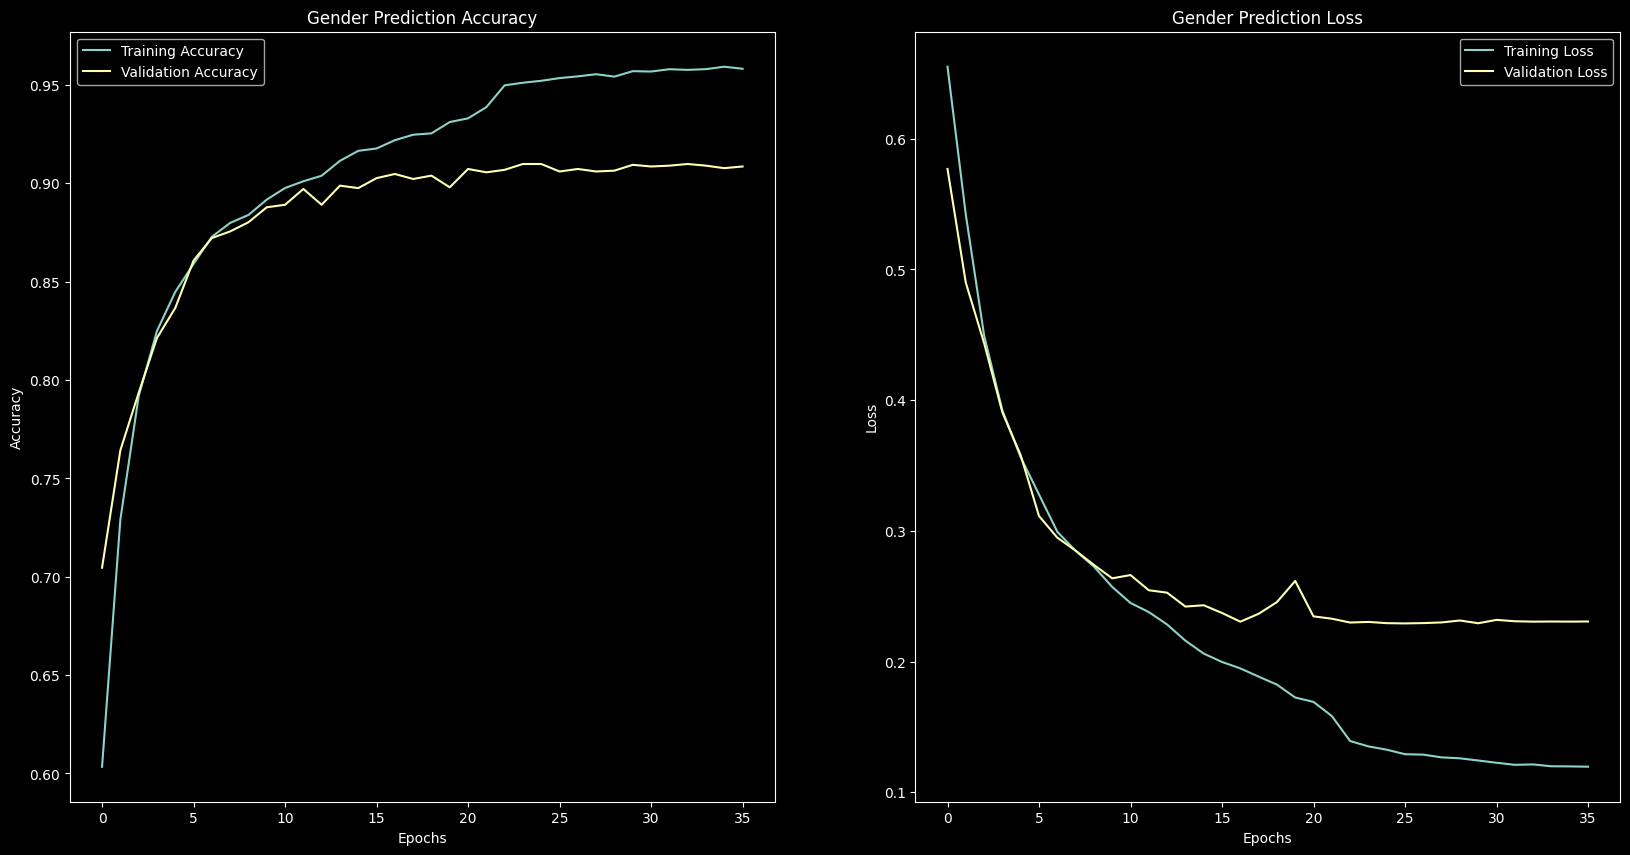

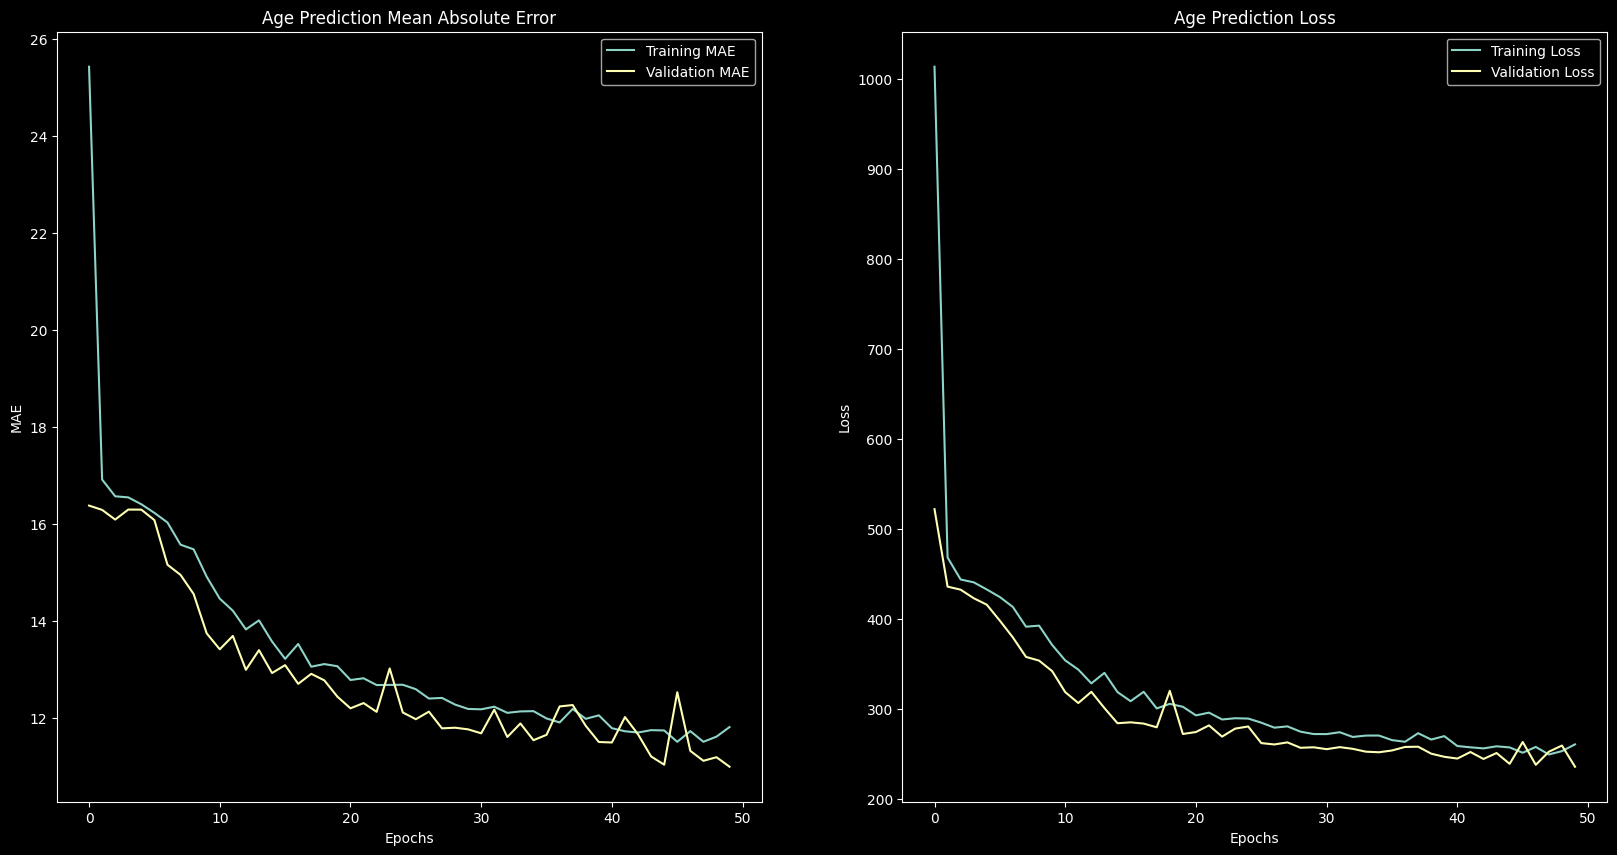

In [143]:
# Plotting for Gender Prediction Model
plt.figure(figsize=(20, 10))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_gender_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_gender_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Gender Prediction Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_gender_model.history['loss'], label='Training Loss')
plt.plot(history_gender_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gender Prediction Loss')
plt.legend()

plt.show()

# Plotting for Age Prediction Model
plt.figure(figsize=(20, 10))

# Plot MAE
plt.subplot(1, 2, 1)
plt.plot(history_age_model.history['mae'], label='Training MAE')
plt.plot(history_age_model.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Age Prediction Mean Absolute Error')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_age_model.history['loss'], label='Training Loss')
plt.plot(history_age_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Age Prediction Loss')
plt.legend()

plt.show()


# Prediction Function for Age and Gender

In [144]:
# Image processing (opening the image, img dimensions, resizing)
from PIL import Image
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((224,224), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((224,224), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)

    # Preparing img for model input
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0 # normalization
    ar = ar.reshape(-1, 224, 224, 3) # reshaping to a 4D tensor

    # Age and Gender Prediction
    age = age_model.predict(ar)
    gender = np.round(gender_model.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'

    # Output
    print('Age:', int(age), '\n','Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Age: 33 
 Gender: female


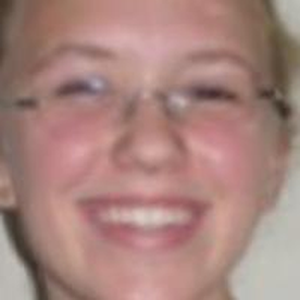

In [153]:
process_and_predict('./age_gender_destination_folder/crop_part1/17_1_0_20170104013458371.jpg.chip.jpg')

Saving the model in google colab

In [95]:
model.save('low_light_final_basic_model.h5')

In [74]:
model.save('low_light_final_basic_model.keras')